<a href="https://www.kaggle.com/code/m000sey/fantasy-baseball-eda?scriptVersionId=151189221" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Preface</span>
- I wanted to analyze something I'm passionate about, so I took a closer look at my fantasy baseball league
- Specifically, I explored what makes a manager have the best final rank
- Some factors like moves, which are transactions a manager can make, highly influence where they stand. 
- Other factors outside of their control, until recently, have very little influence over their final ranks. 

 <a id="table"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Table of contents</span>

[1. Import libraries and data](#1)

[2. Data cleaning and curating](#2)

[3. Data normalization](#3)

[4. Graph 1: Moves vs final rank](#4)

[5. Graph 2: Moves vs playoffs](#5)

[6. Graph 3: Draft position vs final rank](#6)

[7. Graph 4: Avg. moves by team](#7)

[8. Graph 5: Playoff percentage by team](#8)

[9. Graph 6: Category scores by team](#9)

[10. Table 1: Bread n' Butter categories by team](#10)

[11. Table 2: Avg. hitting and pitching scores by team](#11)

[11. Table 3: Tee or Toss?](#12)

[11. List 1: Rankings of top 20 players drafted since 2016](#13)

<a id="1"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Import libraries and data</span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
print("libraries uploaded...")

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the data
data = pd.read_csv('/kaggle/input/sandlot-fantasy-baseball-league-data/fantasy_data.csv')
draft = pd.read_csv('/kaggle/input/sandlot-fantasy-baseball-league-data/draft_info.csv')
print("data imported...")

libraries uploaded...
data imported...


<a id="2"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Data cleaning and curating</span>
- Reordered and renamed some columns to something that makes sense for me.
- Remapped values depending on league size so that better placement means a higher value.
- Reconfigured ERA and WHIP so that higher ERA values mean better ERA value (1 - ERA, and 1 - WHIP)

In [2]:
# Reorder columns
new_order = ['index', 'team', 'R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 'K', 'QS', 'W',
             'SV', 'ERA', 'WHIP', 'league_size', 'MOVES', 'bye', 'playoffs', 'win_percentage',
             'year', 'ring_count', 'draft_position','regular_rank', 'final_rank',]

data = data.reindex(columns=new_order)
print("data columns reorganized")

# Modify some columns
data.drop(['index'], axis=1, inplace=True)
# data.drop(['team'], axis=1, inplace=True)
data.rename(columns={'MOVES': 'moves'}, inplace=True)

# Remap values so better placement == higher value
rank_mapping_12 = {12: 1, 11: 2, 10: 3, 9: 4, 8: 5, 7: 6, 6: 7, 5: 8, 4: 9, 3: 10, 2: 11, 1: 12}
rank_mapping_10 = {10: 1, 9: 2, 8: 3, 7: 4, 6: 5, 5: 6, 4: 7, 3: 8, 2: 9, 1: 10}
rank_mapping_8  = {8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8}

def remap_ranks(row):
    league_size = row['league_size']
    if league_size == 12:
        mapped_regular_reg_rank   = rank_mapping_12.get(row['regular_rank'])
        mapped_regular_final_rank = rank_mapping_12.get(row['final_rank'])
    elif league_size == 10:
        mapped_regular_reg_rank   = rank_mapping_10.get(row['regular_rank'])
        mapped_regular_final_rank = rank_mapping_10.get(row['final_rank'])
    elif league_size == 8:
        mapped_regular_reg_rank   = rank_mapping_8.get(row['regular_rank'])
        mapped_regular_final_rank = rank_mapping_8.get(row['final_rank'])
    else:
        mapped_regular_reg_rank   = row['regular_rank']
        mapped_regular_final_rank = row['final_rank']
    
    return pd.Series({
        'regular_rank': mapped_regular_reg_rank,
        'final_rank': mapped_regular_final_rank,  
    })

data[['regular_rank', 'final_rank']] = data.apply(remap_ranks, axis=1)

# Reverse the direction of ERA and WHIP so greater is better
data['ERA'] = 1 - data['ERA']
data['WHIP'] = 1 - data['WHIP']

# map bools to values
data['playoffs'] = data['playoffs'].map({False: 0, True: 1})
data['bye'] = data['bye'].map({False: 0, True: 1})

data columns reorganized


<a id="3"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Data normalization</span>
- Normalized each year to have even comparisons between each year. For example, leading the league with 600 runs in 2016 might get you in 5th place in 2021. Or the 500 moves that Jordan once made don't overshadow the restricted moves we are permitted today. 
- To do this, I applied a MinMaxScaler transform to the data for each year such that highest values will have a value of 1 and lowest values will have a value of 0. Keep this in mind when reading some graphs. 

In [3]:
# Normalize values based on league size
def replace_bye_column(row):
    league_size = row['league_size']
    
    if league_size == 12:
        row.loc['bye'] = (row['regular_rank'] == 12) | (row['regular_rank'] == 11)
    elif league_size == 10:
        row.loc['bye'] = (row['regular_rank'] == 10) | (row['regular_rank'] == 9)
    elif league_size == 8:
        row.loc['bye'] = (row['regular_rank'] == 8) | (row['regular_rank'] == 7)
    return row

data = data.apply(replace_bye_column, axis=1)

groups = data.groupby('year')
scaler = MinMaxScaler()

# Create an empty list to store DataFrames for each group (year)
standardized_data_list = []

# Define the columns to standardize
COL = ['R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 
       'K', 'QS', 'W', 'SV', 'ERA', 'WHIP', 
       'moves', 'draft_position', 'regular_rank', 'final_rank']

# Create a StandardScaler
scaler = MinMaxScaler()

# Iterate through each group (year) and standardize the data within that group
standardized_data_list = []
for year, group_df in groups:
    # Select the columns you want to standardize
    group_df[COL] = scaler.fit_transform(group_df[COL])
    
    # Append the standardized data for the current year to the list
    standardized_data_list.append(group_df)

# Concatenate all DataFrames in the list along rows to create the final standardized DataFrame
data = pd.concat(standardized_data_list, ignore_index=True)

<a id="4"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Graph 1: Moves vs final rank</span>
- I had to remove 2018 from the pool because the moves data was corrupted or incorrect. This is why Ben's championship won't appear.

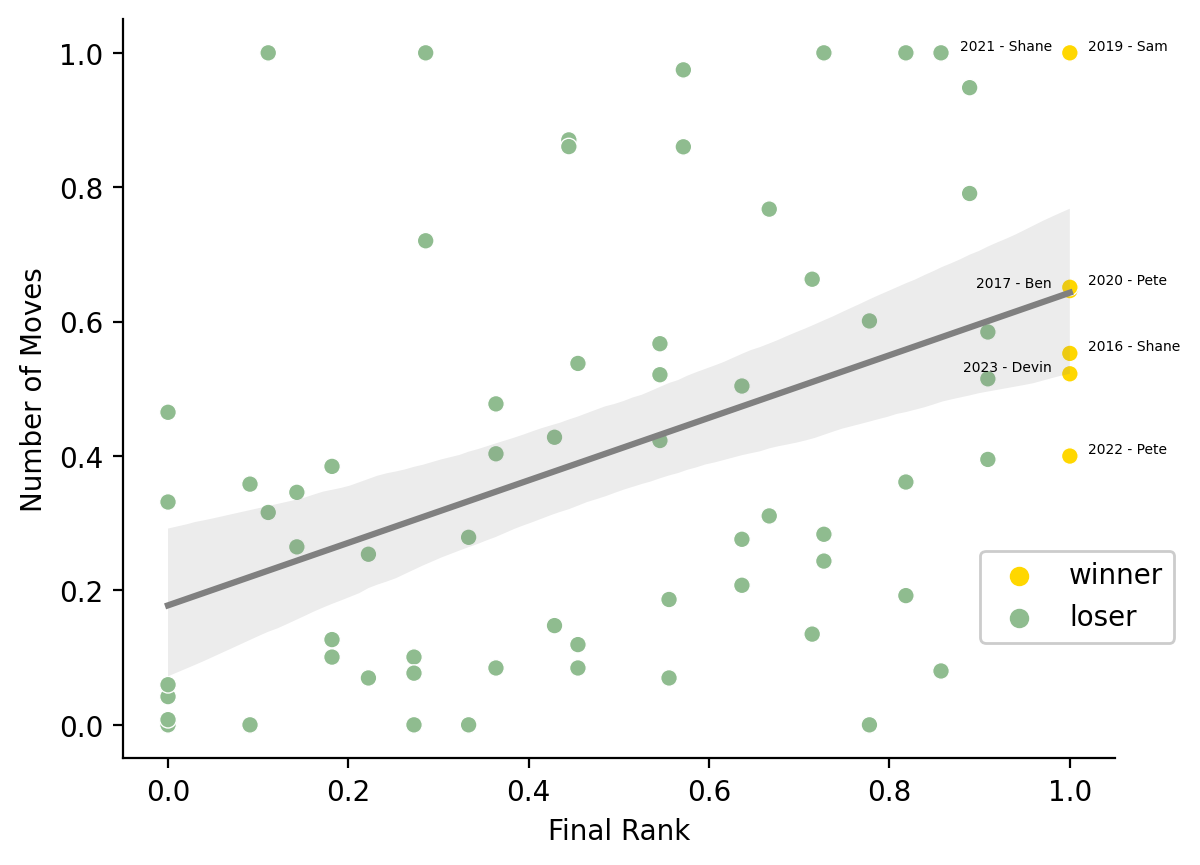

In [4]:
data['hue_color'] = np.where(np.isclose(data['final_rank'], 1, atol=1e-9), 'winner', 'loser')
filtered_data = data[data['year'] != 2018]
winners = filtered_data.query('hue_color == "winner"')
winners = winners.sort_values(by='moves')
custom_palette = {'winner': 'gold', 'loser': 'darkseagreen'}
plt.figure(dpi=200)
sns.scatterplot(x='final_rank', y='moves', hue='hue_color', palette=custom_palette, data=filtered_data)
plt.title(None)
for i, (index, row) in enumerate(winners.iterrows()):
    text = f"{row['year']} - {row['team']}"
    
    # Stagger every other label
    if i % 2 == 0:
        plt.text(row['final_rank'] + 0.02, row['moves'], text, fontsize=5, ha='left', va='bottom')
    else:
        plt.text(row['final_rank'] - 0.02, row['moves'], text, fontsize=5, ha='right', va='bottom')

sns.regplot(x='final_rank', y='moves', data=filtered_data, scatter=False, color='grey', ci=95)

plt.xlabel('Final Rank')
plt.ylabel('Number of Moves')
legend = plt.legend(bbox_to_anchor=(0.85, .3), loc='upper left')
legend.get_frame().set_facecolor('white')  # Set legend box color
legend.get_frame().set_alpha(1)  # Set legend box transparency
sns.despine(right=True, top=True)
plt.show()

# ⚾ Insights ⚾
- There's a clear linear trend for number of moves and your final ranking
- This is a clear indication to me that those that pay attention have better results
- Also, this supports the 'Burn n' Churn' strategy
- **Note:** These data are collected after playoffs, which can influence the number of moves made for those that make playoffs.

<a id="5"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Graph 2: Moves vs playoffs</span>
- I had to remove 2018 from the pool because the moves data was corrupted or incorrect. This is why Ben's championship won't appear.
- Values outside of the IQR (interquartile range) appear as dots outside of the whiskers and are considered outliers.

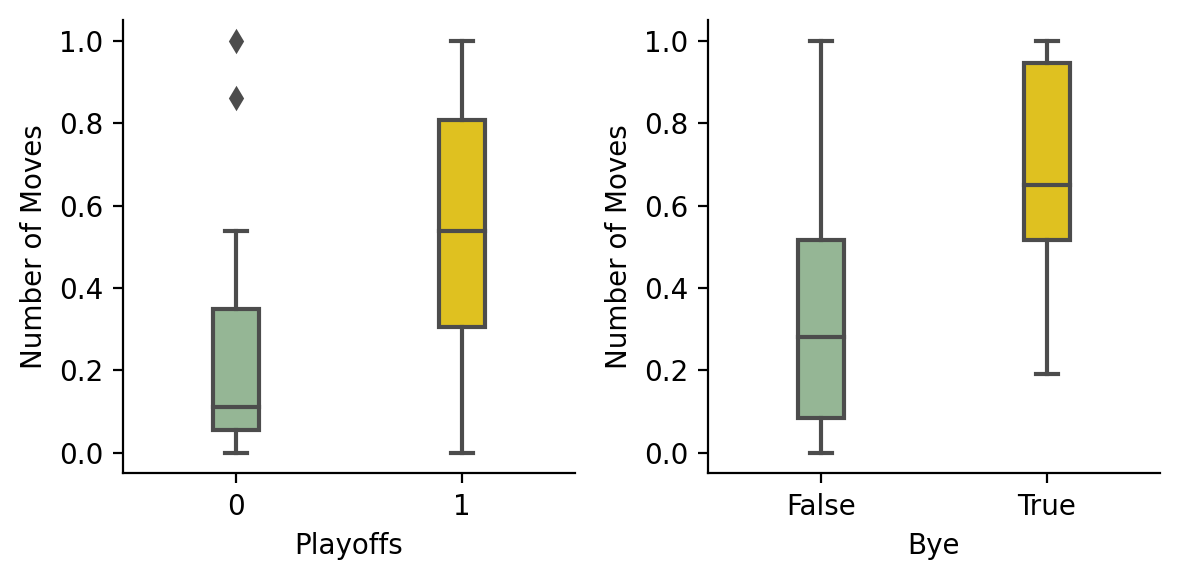

In [5]:
filtered_data = data[data['year'] != 2018]

custom_palette = {True: 'gold', False: 'darkseagreen'}
fig = plt.figure(figsize=(6, 3), dpi=200)

# Create a 1x2 grid (1 row, 2 columns)
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Boxplot for 'playoffs'
ax0 = plt.subplot(gs[0])
sns.boxplot(x='playoffs', y='moves', palette=custom_palette, data=filtered_data, width=0.2, ax=ax0)
ax0.set_xlabel('Playoffs')
ax0.set_ylabel('Number of Moves')
ax0.set_title(None)
sns.despine(right=True, top=True)

# Boxplot for 'bye'
ax1 = plt.subplot(gs[1])
sns.boxplot(x='bye', y='moves', palette=custom_palette, data=filtered_data, width=0.2, ax=ax1)
ax1.set_xlabel('Bye')
ax1.set_ylabel('Number of Moves')
ax1.set_title(None)
sns.despine(right=True, top=True)

plt.tight_layout()
plt.show()

# ⚾ Insights ⚾
- There've only been two outlier circumstances where high move players don't make playoffs. 
- **Note:** Still totally possible to make playoffs with less moves.
- High move makers are much more likely to win a first round bye

<a id="6"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Graph 3: Draft position vs final rank</span>
- Remember this is normalized 0 to 1, so that I can compare between different league sizes. 0 means first pick and 1 means last pick.

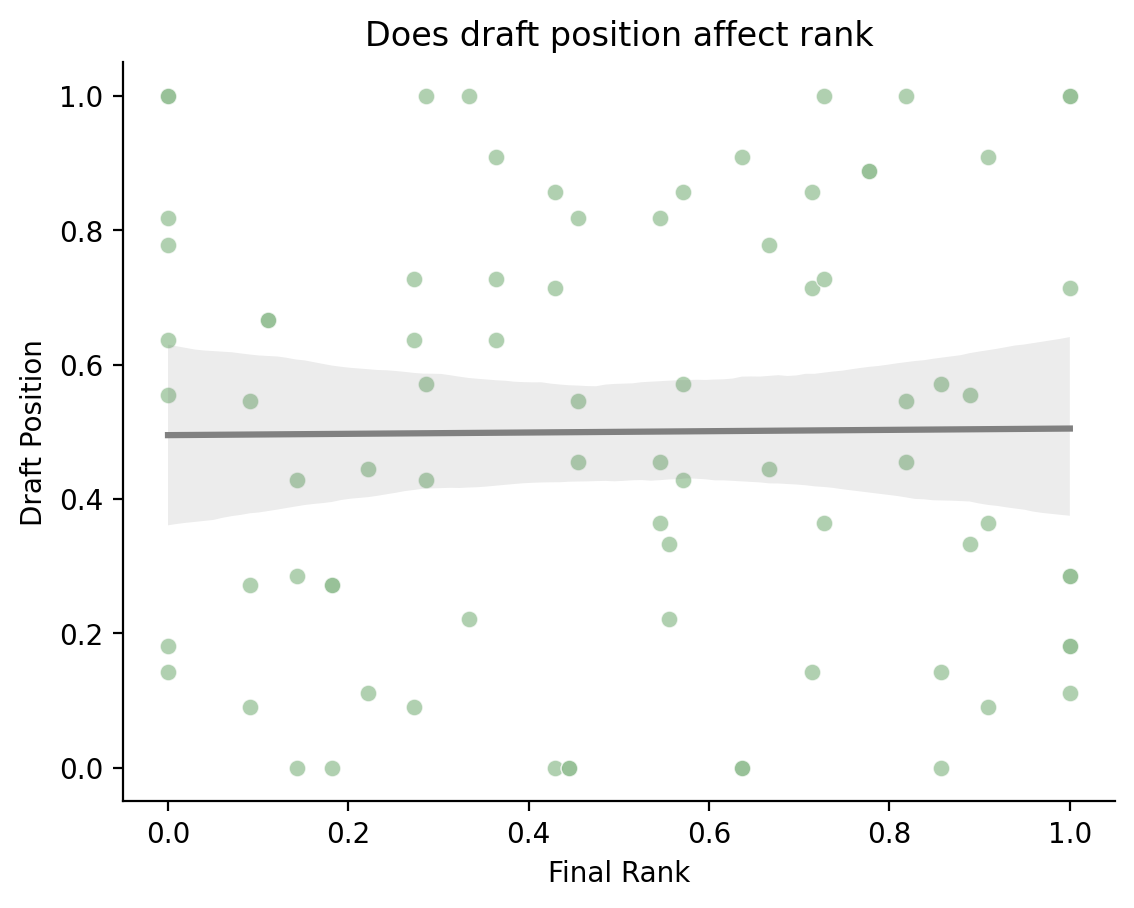

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=200)
sns.scatterplot(x='final_rank', y='draft_position', data=data, alpha=0.7, color='darkseagreen')
sns.regplot(x='final_rank', y='draft_position', data=data, scatter=False, color='grey', ci=95)
plt.xlabel('Final Rank')
plt.ylabel('Draft Position')
plt.title('Does draft position affect rank')
sns.despine(right=True, top=True)
plt.show()

# ⚾ Insights ⚾
- I've never seen a flatter line. The flat line indicates no relationship. If there was a large linear slope, either positive or negative, it would indicate some advatange for a draft slot. 
- When it's all said and done, draft position, when looked at from 2016-2023, has very little influence over your final rank.
- Obviously, depending on the year, you might have a situation whereby a certain draft strategy yields better results, but that doesn't come to bear in the aggregate data.
- Folks should stress less about their draft position slot because it doesn't seem that important. 
- I'm interested to see whether picking your draft slot may have an influence over draft position vs final rank.

<a id="7"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Graph 4: Average moves by team</span>
- Remember, I can't include the 2018 data, but still counted Ben's ring.

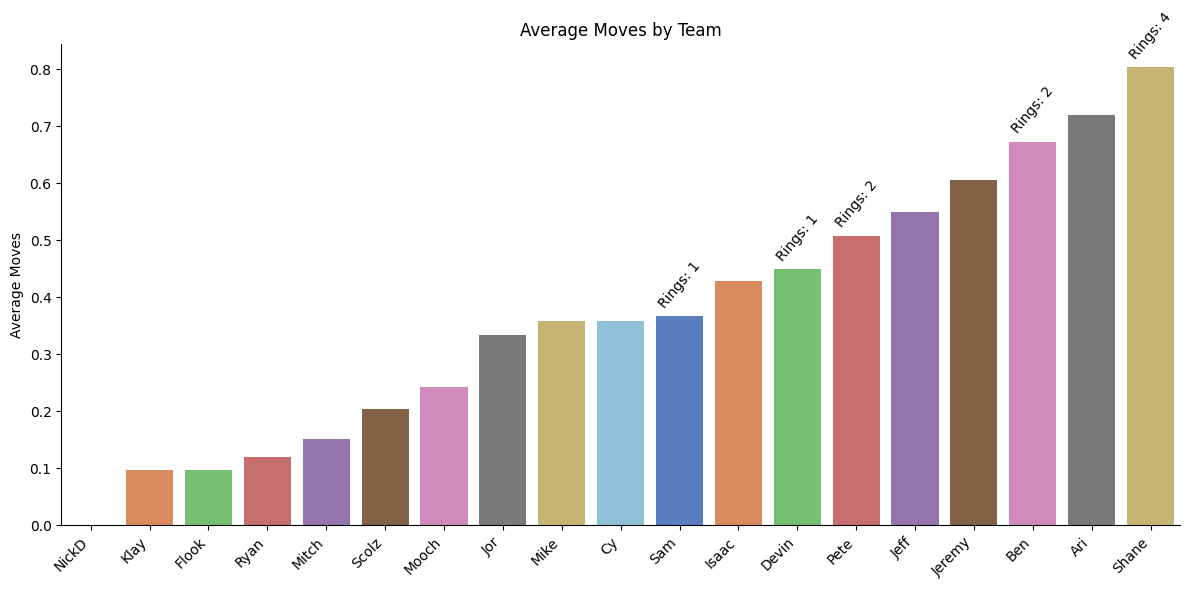

In [7]:
# Define the ring counts dictionary
filtered_data = data[data['year'] != 2018]

# Define the ring counts dictionary
ring_counts = {
    'Shane': 4,
    'Ben': 2,
    'Pete': 2,
    'Sam': 1,
    'Devin': 1
}

unique_teams = data['team'].unique()
team_data_dict = {}

for team in unique_teams:
    team_data = filtered_data[filtered_data['team'] == team]
    team_count = len(team_data)
    total_moves = team_data['moves'].sum()
    average_moves = total_moves / team_count
    
    # Check if the team is in the ring_counts dictionary
    if team in ring_counts:
        rings_label = f'Rings: {ring_counts[team]}'
    else:
        rings_label = ''
    
    team_data_dict[team] = {'average_moves': average_moves, 'rings_label': rings_label}

sorted_teams = sorted(team_data_dict, key=lambda x: team_data_dict[x]['average_moves'])

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_teams, y=[team_data_dict[team]['average_moves'] for team in sorted_teams], palette='muted')
plt.xlabel('')
plt.ylabel('Average Moves')
plt.title('Average Moves by Team')

# Label the rings above each bar for teams with rings
for team in sorted_teams:
    rings_label = team_data_dict[team]['rings_label']
    if rings_label:
        plt.text(sorted_teams.index(team), team_data_dict[team]['average_moves'] + 0.01, rings_label,
                 ha='center', va='bottom', rotation=50)

sns.despine(right=True, top=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ⚾ Insights ⚾
- Those that have more moves on average have more rings. But, having the most moves doesn't always guarantee a championship. 
- **Note:** There's a clear difference in strategy between Pete and Jeremy. Pete is famous for a moderate number of moves and "sticking with his guys", which has really worked out for him, however, Jeremy's ruthless high number of moves never awarded him a ring. 
- **Note:** Sam's average moves are a little misleading. In his one championship season, he had the highest number of moves, but there were years he struggled to stay active. 
- Notice how how managers who average in the bottom third of average moves over their career never earned a ring. 
- NickD's value is 0 because there wasn't one year that he didn't have the fewest number of moves.

<a id="8"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Graph 5: Playoff percentage by team</span>

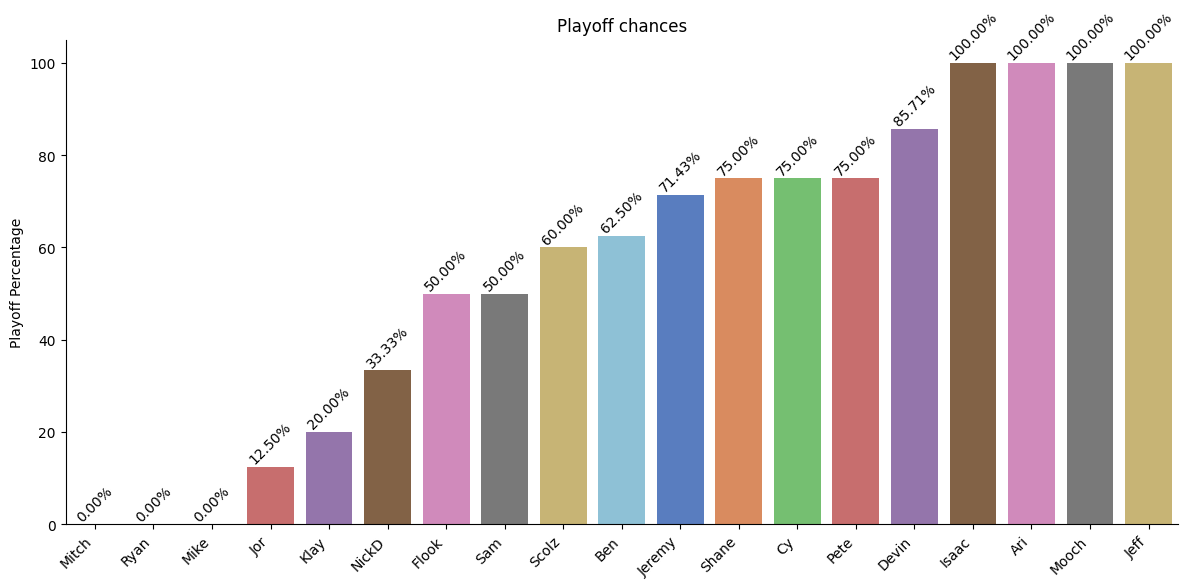

In [8]:
unique_teams = data['team'].unique()
team_data_dict = {}

for team in unique_teams:
    team_data = data[data['team'] == team]
    team_count = len(team_data)
    
    # Count the number of playoff appearances
    playoff_count = team_data['playoffs'].sum()
    
    # Calculate playoff percentage
    playoff_percentage = (playoff_count / team_count) * 100
    
    team_data_dict[team] = {'playoff_percentage': playoff_percentage}

sorted_teams = sorted(team_data_dict, key=lambda x: team_data_dict[x]['playoff_percentage'])

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_teams, y=[team_data_dict[team]['playoff_percentage'] for team in sorted_teams], palette='muted')
plt.xlabel('')
plt.ylabel('Playoff Percentage')
plt.title('Playoff chances')

# Label the playoff percentage above each bar
for team in sorted_teams:
    plt.text(sorted_teams.index(team), team_data_dict[team]['playoff_percentage'] + 0.1, f"{team_data_dict[team]['playoff_percentage']:.2f}%",
             ha='center', va='bottom', rotation=45)
sns.despine(right=True, top=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ⚾ Insights ⚾
- Big shout out to Jeff and Mooch for their success despite being new. They've managed to make playoffs each of the years they've played. Keep up the good work. 

<a id="9"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Graph 6: Category score by team</span>
- This category score was calculated by adding all the normalized scores for each team for each year together, and then averaging those depending on the team.

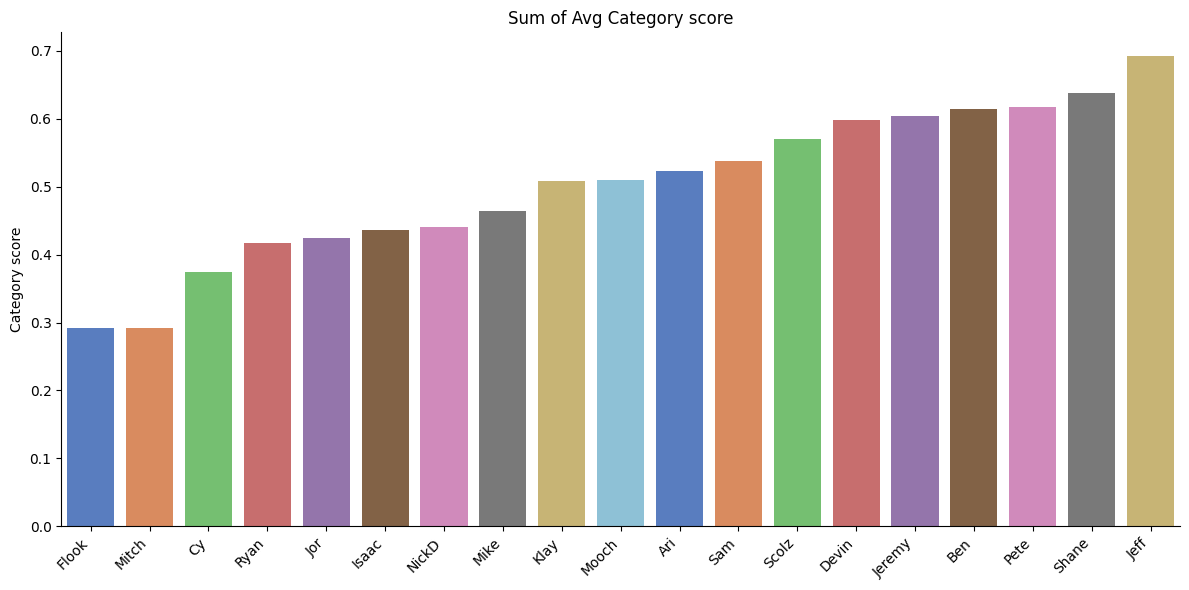

In [9]:
# Assuming 'data' DataFrame is already defined
col_cat = ['R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 'K', 'QS', 'W', 'SV', 'ERA', 'WHIP']

data['sum'] = data[col_cat].sum(axis=1) / 12

average_sum_per_team = data.groupby('team')['sum'].mean().reset_index()

sorted_teams = average_sum_per_team.sort_values(by='sum', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='team', y='sum', data=sorted_teams, palette='muted')
plt.xlabel('')
plt.ylabel('Category score')
plt.title('Sum of Avg Category score')
plt.xticks(rotation=45, ha='right')
sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

# ⚾ Insights ⚾
- **Note:** this includes the playoffs so those that make it artificially increase some of their counting stats. 

<a id="10"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Table 1: Bread n' Butter categories by team</span>
- This table shows your three top categories (in order from 1st best on left, 2nd best in middle, and 3rd best on right). 
- This was calculated by creating an average sum score for each of your normalized categories and then simple ordering those scores.

In [10]:
col_cat = ['R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 'K', 'QS', 'W', 'SV', 'ERA', 'WHIP']

unique_teams = data['team'].unique()

top_columns_dict = {}

for team in unique_teams:
    team_data = data[data['team'] == team]
    
    # Calculate the sum for each category
    for category in col_cat:
        category_sum_col = f'{category}_sum'
        data.loc[data['team'] == team, category_sum_col] = team_data[category].sum() / len(team_data)
    
    # Get the top 3 columns based on sum (without _sum)
    top_columns = data.columns[data.columns.str.endswith('_sum')].to_list()
    top_columns.sort(key=lambda x: data.loc[data['team'] == team, x].iloc[0], reverse=True)
    top_columns = [col[:-4] for col in top_columns[:3]]  # Remove the _sum part
    top_columns_dict[team] = top_columns

# Display the top 3 columns for each team
for team, top_columns in top_columns_dict.items():
    print(f"{team}: {', '.join(top_columns)}")

Shane: K, QS, HR
Cy: OBP, AVG, RBI
Flook: SV, AVG, SB
Ben: K, QS, W
Devin: SB, AVG, R
Jeremy: HR, ERA, WHIP
Mitch: AVG, OBP, SV
Jor: SV, WHIP, QS
Isaac: SV, RBI, ERA
Ari: HR, RBI, QS
Sam: OBP, ERA, K
Klay: WHIP, HR, RBI
Scolz: RBI, AVG, K
NickD: R, WHIP, ERA
Pete: W, R, QS
Mooch: R, RBI, ERA
Jeff: QS, K, W
Ryan: RBI, ERA, WHIP
Mike: ERA, OBP, RBI


<a id="11"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Table 2: Hitting vs pitching by team</span>
- This was calculated in a similar way to the last table, but those average scores corresponding to hitting were separated from those of pitching.

In [11]:
hitting_cat = ['R_sum', 'HR_sum', 'RBI_sum', 'SB_sum', 'AVG_sum', 'OBP_sum']
pitching_cat = ['K_sum', 'QS_sum', 'W_sum', 'SV_sum', 'ERA_sum', 'WHIP_sum']

data['hitting'] = data[hitting_cat].sum(axis=1)
data['pitching'] = data[pitching_cat].sum(axis=1)

unique_teams = data['team'].unique()

for team in unique_teams:
    team_data = data[data['team'] == team]
    hitting_sum = team_data['hitting'].iloc[0].round(2)
    pitching_sum = team_data['pitching'].iloc[0].round(2)
    print(f"{team}: Hitting - {hitting_sum}, Pitching - {pitching_sum}")

Shane: Hitting - 3.6, Pitching - 4.05
Cy: Hitting - 2.77, Pitching - 1.71
Flook: Hitting - 1.88, Pitching - 1.63
Ben: Hitting - 3.25, Pitching - 4.13
Devin: Hitting - 3.81, Pitching - 3.37
Jeremy: Hitting - 3.72, Pitching - 3.54
Mitch: Hitting - 2.22, Pitching - 1.28
Jor: Hitting - 2.13, Pitching - 2.97
Isaac: Hitting - 2.01, Pitching - 3.23
Ari: Hitting - 3.26, Pitching - 3.01
Sam: Hitting - 3.15, Pitching - 3.3
Klay: Hitting - 3.25, Pitching - 2.85
Scolz: Hitting - 3.73, Pitching - 3.12
NickD: Hitting - 3.09, Pitching - 2.19
Pete: Hitting - 3.57, Pitching - 3.85
Mooch: Hitting - 3.31, Pitching - 2.81
Jeff: Hitting - 4.02, Pitching - 4.3
Ryan: Hitting - 2.19, Pitching - 2.81
Mike: Hitting - 2.93, Pitching - 2.64


<a id="12"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Table 3: Tee or Toss?</span>
- What's your team's key to victory? 
- I simply implemented the scores from the last table, but listed tee if your team was better at hitting or toss if your team's focus is pitching

In [12]:
hitting_cat = ['R_sum', 'HR_sum', 'RBI_sum', 'SB_sum', 'AVG_sum', 'OBP_sum']
pitching_cat = ['K_sum', 'QS_sum', 'W_sum', 'SV_sum', 'ERA_sum', 'WHIP_sum']

# Create new columns 'hitting' and 'pitching'
data['hitting'] = data[hitting_cat].sum(axis=1)
data['pitching'] = data[pitching_cat].sum(axis=1)

# Create a new column 'toss_tee'
data['toss_tee'] = data.apply(lambda row: 'toss' if row['pitching'] > row['hitting'] else 'tee', axis=1)

# Get the unique teams
unique_teams = data['team'].unique()

# Print each team and their first associated 'toss_tee' value
for team in unique_teams:
    team_data = data[data['team'] == team]
    first_toss_tee = team_data['toss_tee'].iloc[0]
    print(f"{team}: {first_toss_tee}")

Shane: toss
Cy: tee
Flook: tee
Ben: toss
Devin: tee
Jeremy: tee
Mitch: tee
Jor: toss
Isaac: toss
Ari: tee
Sam: toss
Klay: tee
Scolz: tee
NickD: tee
Pete: toss
Mooch: tee
Jeff: toss
Ryan: toss
Mike: tee


<a id="13"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">List 1: Rankings of the top 20 players drafted since 2016?</span>

In [13]:
draft.rename(columns={'draft number': 'draft_num'}, inplace=True)
draft['draft_num'] = draft['draft_num'].max() + 1 - draft['draft_num']

unique_players = draft['player'].unique()
unique_players_sorted = sorted(unique_players)

num_unique_players = len(unique_players_sorted)

print(f"Number of unique players:     {num_unique_players}")

draft.rename(columns={'draft number': 'draft_num'}, inplace=True)

player_sum_dict = {}

for player in draft['player'].unique():
    player_data = draft[draft['player'] == player]
    draft_sum = player_data['draft_num'].sum()
    player_sum_dict[player] = draft_sum

draft_sum_df = pd.DataFrame(list(player_sum_dict.items()), columns=['Player', 'draft_sum'])
draft_sum_df = draft_sum_df.sort_values(by='draft_sum', ascending=False)

print(draft_sum_df.to_string(index=False))

Number of unique players:     65
               Player  draft_sum
           Mike Trout        129
         Mookie Betts        101
         Bryce Harper         82
        Nolan Arenado         76
        Manny Machado         72
         Max Scherzer         71
          Trea Turner         71
     Paul Goldschmidt         69
          Jose Altuve         60
            Juan Soto         50
         Jose Ramirez         47
          Gerrit Cole         46
      Freddie Freeman         46
      Clayton Kershaw         44
     Ronald Acuna Jr.         40
     Francisco Lindor         39
       Cody Bellinger         36
       Josh Donaldson         35
           Chris Sale         34
        Carlos Correa         30
Vladimir Guerrero Jr.         29
        J.D. Martinez         29
          Kyle Tucker         28
     Charlie Blackmon         24
        Corbin Burnes         22
          Bo Bichette         22
         Corey Kluber         21
        Anthony Rizzo         20
     Chris